# Compare with FieldFox notebook

This notebook shows the SLVNA result and the FieldFox N9916A Microwave Analyzer result together in a `matplotlib` plot. The device under test is a HP 537A cavity tunable from 3.7-12.4 GHz, set to 7.00 GHz. From the FieldFox VNA, .csv files are exported to the [measure/ffvna](measure/ffvna) directory. The SLVNA data files in [measure/slvna](measure/slvna) are saved as shown in [simple_api_usage.ipynb](simple_api_usage.ipynb).


## Setup

In [1]:
import os
import matplotlib.pyplot as mpl
import xarray as xr
from pandas import read_csv
from numpy import linspace, pi, unwrap

In [2]:
DATA_PATH = os.path.join(os.path.realpath(os.curdir), "measure")
"""Path to measurement data files"""
display()

## Helper functions

In [3]:
from genericpath import isfile
from numpy import ndarray


def remove_linear_phase(freq_array: ndarray, phase_array: ndarray) -> ndarray:
    """Unwraps the phase array in radians and adds the average slope to it."""
    ph_unwrapped = unwrap(phase_array)
    first_ph, last_ph = ph_unwrapped[[0, -1]]
    first_f, last_f = freq_array.iloc[[0, -1]]
    avg_slope = (last_ph - first_ph) / (last_f - first_f)
    return ph_unwrapped - linspace(0, last_f - first_f, num=ph_unwrapped.shape[0]) * avg_slope


def comparison_plot(hdf5: str, csv_mag: str, csv_ph: str) -> None:
    """Plots the latest .hdf5 data file from the SLVNA with the given csv file from the FieldFox."""
    for file in {hdf5, csv_mag, csv_ph}:
        if not os.path.isfile(file):
            raise FileNotFoundError(file)

    # Load SLVNA .hdf5 file.
    pdf_slvna = xr.load_dataset(hdf5).as_numpy()
    pdf_slvna = pdf_slvna.reset_index("f")  # Move the index (frequency) into a column.

    # Load FieldFox .csv file for magnitude.
    pdf_ffvna = read_csv(csv_mag, comment="!", names=("frequency_Hz", "s21_dB"), delimiter=",")
    pdf_ffvna = pdf_ffvna.dropna().astype(float)  # Delete the BEGIN and END keywords.

    # Load FieldFox .csv file for phase.
    pdf_ph = read_csv(csv_ph, comment="!", names=("frequency_Hz", "s21_rad"), delimiter=",")
    pdf_ffvna = pdf_ffvna.merge(pdf_ph.dropna().astype(float))  # Delete the BEGIN and END keywords and merge phase column.
    pdf_ffvna.loc[:, "s21_rad"] *= pi / 180  # rad2deg
    pdf_ffvna.loc[:, "s21_rad"] += pi  # offset
    pdf_ffvna.loc[:, "s21_rad"] = remove_linear_phase(pdf_ffvna.loc[:, "frequency_Hz"], pdf_ffvna.loc[:, "s21_rad"])

    # Setup plot.
    fig, (ax_mag, ax_ph) = mpl.subplots(nrows=1, ncols=2, figsize=(13, 5))
    ax_mag.set_title(r"$S_{21}$ magnitude comparison SLVNA & FieldFox N9916A")
    ax_mag.set_ylabel(r"|$S_{21}$| (dB)")
    ax_ph.set_title(r"$S_{21}$ unwrapped phase comparison SLVNA & FieldFox N9916A")
    ax_ph.set_ylabel(r"$\angle S_{21}$ (rad)")

    # Draw SLVNA trace.
    ax_mag.plot(pdf_slvna["f"], pdf_slvna["S_21_mag_dB"], color="darkgreen", label="SLVNA")
    ax_ph.plot(pdf_slvna["f"], pdf_slvna["S_21_phase_unwrapped"], color="darkgreen", label="SLVNA")

    # Draw FieldFox trace.
    pdf_ffvna.plot.line(x="frequency_Hz", y="s21_dB", ax=ax_mag, color="purple", label=r"FFVNA")
    pdf_ffvna.plot.line(x="frequency_Hz", y="s21_rad", ax=ax_ph, color="purple", label=r"FFVNA")

    # Overwrite x label.
    ax_mag.set_xlabel("frequency (Hz)")
    ax_ph.set_xlabel("frequency (Hz)")
    ax_mag.legend()
    ax_ph.legend()

    return fig


## Plot

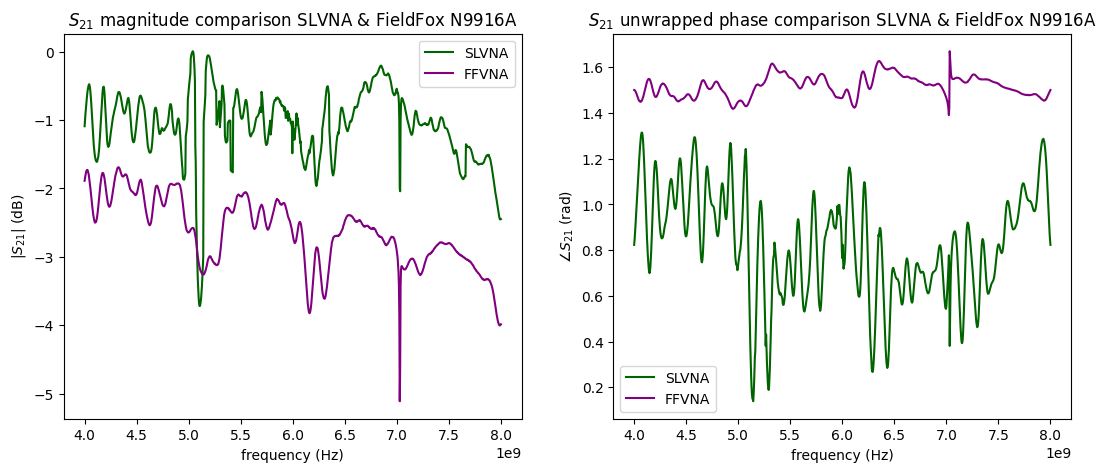

In [4]:
_ = comparison_plot(
    os.path.join(DATA_PATH, "slvna", "cavity_data.hdf5"),  # SLVNA data
    os.path.join(DATA_PATH, "ffvna", "cavity_magnitude.csv"),  # FieldFox magnitude data
    os.path.join(DATA_PATH, "ffvna", "cavity_phase.csv")  # FieldFox phase data
)
